In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mogli
import os
from ipywidgets import IntProgress
from IPython.display import display, clear_output
from PIL import Image

from src.CameraPoseVisualizer import CameraPoseVisualizer

import importlib
import json

In [ ]:
bandgaps = np.loadtxt('Datasets/bandgaps.csv')
cods = np.loadtxt('Datasets/CODids.csv', dtype=int)
materials = mogli.read('Datasets/structures.xyz')

In [ ]:
def circle(radius, n):
    theta = np.linspace(0, 2*np.pi, n)
    x = radius*np.cos(theta)
    y = radius*np.sin(theta)
    z = np.zeros_like(theta)
    # put x,y, and z as columns in a matrix

    return np.column_stack((x.flatten(), y.flatten(), z.flatten()))
# x = circle(100, 20)

# plt.figure(figsize=(10,10))
# plt.plot(x[:,0], x[:,1], 'o')


In [ ]:
def sphere (radius, n):
    theta = np.linspace(0, 2*np.pi, n)
    phi = np.linspace(0, np.pi, n)
    x = radius*np.outer(np.cos(theta), np.sin(phi)).flatten()
    y = radius*np.outer(np.sin(theta), np.sin(phi)).flatten()
    z = radius*np.outer(np.ones(np.size(theta)), np.cos(phi)).flatten()
    
    
    mask = np.logical_and(x != 0, y != 0)
    x = x[mask]
    y = y[mask]
    z = z[mask]
    
    # print(x.shape)
    
    return np.column_stack((x,y,z))
s = sphere(25, 10)
# plot points
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(s[:,0], s[:,1], s[:,2], c='b', marker='o')

In [ ]:
import numpy as np
def normalize (v):
    return v/np.linalg.norm(v)
def create_camera_matrix(camera_position, point_of_view, up_vector):
    camera_position = np.array(camera_position)
    point_of_view = np.array(point_of_view)
    up_vector = np.array(up_vector)
    Z  = normalize(camera_position- point_of_view)
    X = normalize(np.cross(up_vector, Z))
    Y = np.cross(Z, X)
    m = np.identity(4)
    m[:3,0] = X
    m[:3,1] = Y
    m[:3,2] = Z
    m[:3,3] = camera_position
    return m

In [ ]:
def calculate_focal_length(verticalFieldOfView):
    return 1/np.tan(np.radians(verticalFieldOfView))
calculate_focal_length(45)



In [103]:
class Cameraframe():
    def __init__(self,filePath,transform_matrix, sharpness=5725):
        self.file_path = filePath
        self.sharpness= sharpness
        self.transform_matrix = transform_matrix
    def toJson(self):
        return {
            "file_path": self.file_path,
            # "sharpness": self.sharpness,
            "transform_matrix": self.transform_matrix.tolist()
        }
    
class dataset():
    def __init__(self):
        x =  0.5 * 100 / np.tan(0.5 * np.radians(45))
        print(x)
        self.camera_angle_x= np.radians(45)
        self.camera_angle_y= np.radians(45)
        self.fl_x= x
        self.fl_y= x
        self.k1= 0.0
        self.k2= 0.0
        self.p1= 0.0
        self.p2= 0.0
        self.is_fisheye= False
        
        self.w= 100.0
        self.h= 100.0
        self.aabb_scale=  4
        self.frames = []
    def toJson(self):
        return {
            "camera_angle_x": self.camera_angle_x,
            "camera_angle_y": self.camera_angle_y,
            "fl_x": self.fl_x,
            "fl_y": self.fl_y,
            # "k1": self.k1,
            # "k2": self.k2,
            # "p1": self.p1,
            # "p2": self.p2,
            "is_fisheye": self.is_fisheye,
            "cx": self.w / 2,
            "cy": self.h / 2,
            "w": self.w,
            "h": self.h,
            "aabb_scale":self.aabb_scale, 
            "frames": [frame.toJson() for frame in self.frames]             
        }
    def save(self, path):
        with open(path, 'w') as outfile:
            json.dump(self.toJson(), outfile)
        

120.71067811865476
initialize camera pose visualizer


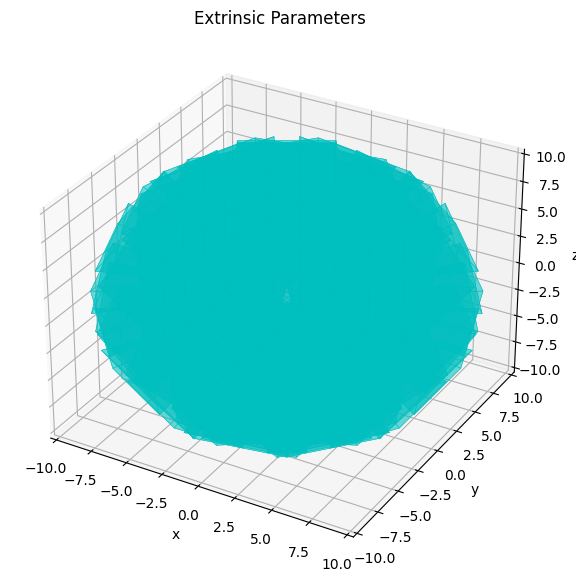

18:28:21 SUCCESS  Initialized CUDA. Active GPU is #0: NVIDIA GeForce RTX 2070 [75]
18:28:21 INFO     Loading NeRF dataset from
18:28:21 INFO       Datasets\3d\100x100_BP1.5\0\nerf.json
18:28:21 PROGRESS [                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

18:28:21 WARNING  Vulkan instance validation layer is not available. Vulkan errors will be difficult to diagnose.


In [104]:
bonds_param = 1.5
width = 100
height = 100
distance = 25
formatFile = "jpg"

importlib.reload(mogli)
path = f'Datasets/3d/{width}x{height}_BP{bonds_param}/'
if not os.path.exists(path):
    os.makedirs(path)    
for i, molecule in enumerate(materials):
    pathmolecule = f'{path}/{i}'
    if not os.path.exists(pathmolecule):
        os.makedirs(pathmolecule)   
    Nerf = dataset()
    data  = {}
    sp = sphere(distance, 10)
    
    data["poses"] = np.zeros((sp.shape[0],4,4),dtype=np.float32)
    data["images"] = np.zeros((sp.shape[0],width,height,3 if formatFile == "jpg" else 4),dtype=np.float32)
    data["focal"] = np.array(1,dtype=np.float32)    
    
    for n , (x,y,z) in enumerate(sp):
              
        img_path = f"{pathmolecule}/molecula_x_{i}_{n}.{formatFile}"
        camerapos = np.array([x,y,z])
        camera = mogli.export(molecule,img_path,bonds_param=bonds_param,camera=((x,y,z),(0, 0, 0),(0 , 0 , 1)), width=width, height=height).T
        # camera = create_camera_matrix([x,y,z],[0, 0, 0],[0 , 0 , 1])                 
        camera[:3,3] =  (camerapos / distance) 
        # camera[:3,3] =  camera[:3,3] / distance
        img =  Image.open(img_path)
        data["poses"][n] = camera
        data["images"][n] = np.array(img)/255.0
        
        Nerf.frames.append(Cameraframe(f"molecula_x_{i}_{n}.{formatFile}",camera))
    Nerf.save(f"{pathmolecule}/nerf.json")   
            
    visualizer = CameraPoseVisualizer([-10, 10], [-10, 10], [-10, 10])

    for pose in data["poses"]:
        visualizer.extrinsic2pyramid(pose, 'c', 10)
    visualizer.show()   

    ! instant-ngp.exe  {pathmolecule} 
    # clear_output(wait=True)    
    # ! python colmap2nerf.py --colmap_matcher exhaustive --run_colmap --aabb_scale 32 --images {pathmolecule} --out {pathmolecule}/nerfBueno.json --overwrite
    # break
        
    # np.savez(f"{pathmolecule}/data.npz", **data)
    break

In [ ]:
np.rad2deg(0.08094121392159942)

In [ ]:
! python colmap2nerf.py --colmap_matcher exhaustive --run_colmap --aabb_scale 4 --images {pathmolecule} --out {pathmolecule}/nerfBueno.json --overwrite


In [ ]:

def loadData(Path):
    x = np.load(Path, allow_pickle=True)
    print(x["images"].shape)
    print(x["poses"].shape)
    return x["images"], x["poses"], x["focal"]


In [ ]:
# for pose in poses:
#     print(pose,"\n")

In [ ]:
path = r"tiny_nerf_data.npz"

images, poses, focal = loadData(path)
visualizer = CameraPoseVisualizer([-50, 50], [-50, 50], [-50, 50])

for pose in poses[:3]:
    
    visualizer.extrinsic2pyramid(pose, 'c', 10)
visualizer.show()  

In [ ]:
path = r"tiny_nerf_data.npz"

images, poses, focal = loadData(path)
visualizer = CameraPoseVisualizer([-50, 50], [-50, 50], [0, 50])

for pose in poses:
    visualizer.extrinsic2pyramid(pose, 'c', 10)
visualizer.show()  